# Employee Sentiment Analysis
Objective:Analyze employee messages to label sentiment, calculate scores, rank employees, identify flight risks, and model sentiment trends.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


In [10]:
import os
os.environ["USE_TF"] = "0"  # disable TensorFlow
os.environ["TRANSFORMERS_NO_ADVISORY_WARNINGS"] = "1"


In [13]:
data = {
    'Employee': ['A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C', 'D'],
    'Message': [
        'I love working here, the team is great!',
        'I am frustrated with management decisions.',
        'Things are okay, not much to say.',
        'Excited about our new project launch!',
        'I am tired of constant pressure and stress.',
        'Happy to receive recognition for my work.',
        'The workload is too high this week.',
        'Had a productive meeting today!',
        'Not feeling appreciated at all.',
        'The new manager is very supportive.'
    ],
    'Date': pd.date_range(start='2024-01-01', periods=10, freq='15D')
}

df = pd.DataFrame(data)
print("Sample Data:")
print(df.head())

Sample Data:
  Employee                                      Message       Date
0        A      I love working here, the team is great! 2024-01-01
1        B   I am frustrated with management decisions. 2024-01-16
2        C            Things are okay, not much to say. 2024-01-31
3        A        Excited about our new project launch! 2024-02-15
4        B  I am tired of constant pressure and stress. 2024-03-01


In [14]:
## SENTIMENT LABELING

analyzer = SentimentIntensityAnalyzer()

def vader_label(text):
    score = analyzer.polarity_scores(str(text))['compound']
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df['Sentiment'] = df['Message'].apply(vader_label)
print("\nSentiment Labeling Completed:")
print(df[['Employee', 'Message', 'Sentiment']])


Sentiment Labeling Completed:
  Employee                                      Message Sentiment
0        A      I love working here, the team is great!  Positive
1        B   I am frustrated with management decisions.  Negative
2        C            Things are okay, not much to say.  Positive
3        A        Excited about our new project launch!  Positive
4        B  I am tired of constant pressure and stress.  Negative
5        C    Happy to receive recognition for my work.  Positive
6        A          The workload is too high this week.   Neutral
7        B              Had a productive meeting today!   Neutral
8        C              Not feeling appreciated at all.  Negative
9        D          The new manager is very supportive.  Positive


C:\Users\preri\AppData\Local\Temp\ipykernel_13820\975947435.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Sentiment', palette='coolwarm')


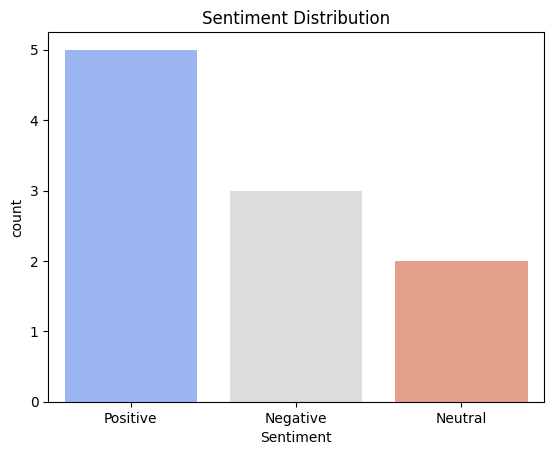


Sentiment Counts by Employee:
Employee  Sentiment
A         Positive     2
          Neutral      1
B         Negative     2
          Neutral      1
C         Positive     2
          Negative     1
D         Positive     1
Name: count, dtype: int64


In [15]:
#EXPLORATORY DATA ANALYSIS (EDA)

sns.countplot(data=df, x='Sentiment', palette='coolwarm')
plt.title('Sentiment Distribution')
plt.show()

print("\nSentiment Counts by Employee:")
print(df.groupby('Employee')['Sentiment'].value_counts())


In [16]:
# MONTHLY SENTIMENT SCORE

sentiment_map = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
df['Sentiment_Score'] = df['Sentiment'].map(sentiment_map)
df['Month'] = df['Date'].dt.to_period('M')

monthly_scores = df.groupby(['Employee', 'Month'])['Sentiment_Score'].sum().reset_index()
print("\nMonthly Sentiment Scores:")
print(monthly_scores)


Monthly Sentiment Scores:
  Employee    Month  Sentiment_Score
0        A  2024-01                1
1        A  2024-02                1
2        A  2024-03                0
3        B  2024-01               -1
4        B  2024-03               -1
5        B  2024-04                0
6        C  2024-01                1
7        C  2024-03                1
8        C  2024-04               -1
9        D  2024-05                1


In [17]:
#EMPLOYEE RANKING

top_positive = monthly_scores.sort_values(['Sentiment_Score', 'Employee'], ascending=[False, True]).groupby('Month').head(3)
top_negative = monthly_scores.sort_values(['Sentiment_Score', 'Employee'], ascending=[True, True]).groupby('Month').head(3)

print("\nTop 3 Positive Employees per Month:")
print(top_positive)
print("\nTop 3 Negative Employees per Month:")
print(top_negative)



Top 3 Positive Employees per Month:
  Employee    Month  Sentiment_Score
0        A  2024-01                1
1        A  2024-02                1
6        C  2024-01                1
7        C  2024-03                1
9        D  2024-05                1
2        A  2024-03                0
5        B  2024-04                0
3        B  2024-01               -1
4        B  2024-03               -1
8        C  2024-04               -1

Top 3 Negative Employees per Month:
  Employee    Month  Sentiment_Score
3        B  2024-01               -1
4        B  2024-03               -1
8        C  2024-04               -1
2        A  2024-03                0
5        B  2024-04                0
0        A  2024-01                1
1        A  2024-02                1
6        C  2024-01                1
7        C  2024-03                1
9        D  2024-05                1


In [18]:
# FLIGHT RISK DETECTION

df['Date'] = pd.to_datetime(df['Date'])
flight_risk = (
    df[df['Sentiment'] == 'Negative']
    .groupby(['Employee', pd.Grouper(key='Date', freq='30D')])
    .size()
    .reset_index(name='Negative_Count')
)
risk_employees = flight_risk[flight_risk['Negative_Count'] >= 4]['Employee'].unique()
print("\n⚠️ Flight Risk Employees:", risk_employees if len(risk_employees) > 0 else "None")



⚠️ Flight Risk Employees: None


In [19]:
#LINEAR REGRESSION (Sentiment Trend Prediction)

df['Message_Length'] = df['Message'].apply(lambda x: len(str(x).split()))
X = df[['Message_Length']]
y = df['Sentiment_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

print("\nModel Evaluation:")
print("Coefficient:", model.coef_[0])
print("Intercept:", model.intercept_)
print("R² Score:", model.score(X_test, y_test))


Model Evaluation:
Coefficient: -0.15384615384615388
Intercept: 1.461538461538462
R² Score: -1.1035502958579881
